## Plan de la présentation

I. Introduction sur les CNN

1. Qu'est ce qu'un CNN
2. Pourquoi avoir choisi de construire un modèle CNN

II. Préparation du dataset

1. Séparation du dataset (train, validation, test)
2. Choix des classes et itération sur le dataset
3. Prétraitement et normalisation des images

III. Construction, entrainement et testing du modèle

1. Construction du modèle
2. Entrainement du modèle
3. Testing de l'efficacité du modèle

IV. Conclusion

V. Quelques sources scientifiques utilisées

## I. Introduction sur les CNN

### 1. Qu'est-ce qu'un CNN

Les CNN sont une catégorie de réseaux de neurones artificiels profonds, principalement utilisés pour traiter des données ayant une topologie de grille, comme les images. Un CNN se compose de plusieurs couches conçues pour reconnaître des patterns de plus en plus complexes au fur et à mesure que les données progressent à travers le réseau.

Les éléments clés qui constituent un CNN incluent :

- **Les layers de convolution**, où des filtres / kernels sont appliqués sur l'entrée pour créer des "feature maps". Cela permet de détécter des spécificités de l'image, comme des bords, des courbes, des concentrations de couleurs etc...
  
- **Les layers de pooling**, qui sont appliqués sur les feature maps pour réduire leur taille. On utilise en général du max pooling 2x2, permettant de garder, sur une matrice de 4 pixels, seulement le pixel max (celui qui a la plus haute valeur en grayscale par exemple). Garder le pixel max permet de réduire la taille de l'image tout en conservant les informations importantes de l'image.
  
- **Les layers de normalisation**, qui aident à accélérer la convergence du réseau en normalisant les entrées de chaque couche. Par exemple, sur une liste de valeurs d'activation de neurone a une étape donnée, la normalisation va convertir toutes ces valeurs à des valeurs entre 0 et 1 (car la sortie est composée de n neurones, n étant le nombre de classes, dont chaque valeur est la probabilité de la prédiction, donc entre 0 et 1, somme = 1)
  
- **Le layer complètement connecté** (ou fully connected layer), où tous les neurones d'une couche sont connectés à chaque neurone de la couche suivante, permettant de classer les données en fonction des caractéristiques extraites par les couches précédentes.

La capacité des CNN à détecter des caractéristiques d'une image par convolution et maxpooling un les rend particulièrement adaptés pour des tâches de vision par ordinateur telles que la classification d'images, la reconnaissance de formes et la détection d'objets.

### 2. Pourquoi avoir choisi de faire un modèle CNN

Les CNN ont été choisis pour ce projet de classification de formes dessinées à la main pour plusieurs raisons :

- **Capacité à extraire des caractéristiques locales** : Les CNN sont capables d'identifier des caractéristiques locales dans des images, comme les bords et les formes simples, qui sont cruciales pour différencier des formes géométriques comme les ellipses, les rectangles et les triangles.
  
- **Invariance spatiale** : Les CNN peuvent reconnaître des formes indépendamment de leur position dans l'image grâce aux opérations de convolution et de pooling, ce qui est idéal pour traiter des dessins à main levée qui peuvent varier en orientation et en position.
  
- **Performance de pointe** : Les CNN ont démontré une performance exceptionnelle sur diverses tâches de vision par ordinateur, y compris la classification d'images, surpassant les approches classiques et d'autres architectures de réseaux de neurones dans de nombreux cas.
  
- **Adaptabilité et apprentissage profond** : La capacité des CNN à apprendre des représentations de données profondes et hiérarchiques leur permet de s'adapter et de généraliser à partir d'un ensemble de données d'entraînement vers de nouvelles formes inédites, ce qui est essentiel pour un système robuste de reconnaissance de formes.

**Références**:
- *Krizhevsky, A., Sutskever, I., & Hinton, G. E. (2012). ImageNet classification with deep convolutional neural networks. In Advances in neural information processing systems (pp. 1097-1105).* Cet article décrit l'architecture AlexNet, un CNN qui a largement remporté le [défi ImageNet LSVRC-2012](https://image-net.org/challenges/LSVRC/2012/results.html) face au state of the art, démontrant l'efficacité des CNN pour la classification d'images.


## II. Préparation du dataset

Commençons a préparer notre dataset. Tout d'abord, importons les librairies nécessaires :

In [1]:
import os
from time import sleep

import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import (
    Activation,
    BatchNormalization,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    Input,
    MaxPooling2D,
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

2024-04-28 22:31:34.120655: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-28 22:31:35.273444: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Initialisons maintenant les variables globales et les constantes nécessaires

In [2]:
main_dir = "data/"
img_size = 70

train_images = []
train_labels = []
validation_images = []
validation_labels = []
test_images = []
test_labels = []
class_names = {}
class_index = 0

Définissions maintenant les classes de sortie, les outputs que doit prédire le modèle, et une fonction utilitaire

In [3]:
shape_classes = {
    "other": 0,
    "ellipse": 1,
    "rectangle": 2,
    "triangle": 3,
}

num_classes = len(shape_classes)

def get_class_name(class_index):
    for class_name, index in shape_classes.items():
        if index == class_index:
            return class_name
    return None

### 1. Séparation du dataset (train, validation, test)

Séparer un dataset en train, validation et test est une pratique standard qui sert à optimiser et évaluer la performance des modèles de manière non biasée.

- La partie d'entraînement est utilisée pour ajuster les paramètres du modèle, c'est-à-dire que le modèle apprend à reconnaître des patterns ou des caractéristiques à partir de cette portion de données.
  
- La partie de validation, quant à elle, est utilisée pour affiner les hyperparamètres du modèle (comme le taux d'apprentissage ou le nombre de couches dans un réseau de neurones) et pour prévenir le surajustement (overfitting), qui survient lorsque le modèle apprend trop bien les données d'entraînement jusqu'à ne pas pouvoir être appliqué sur de nouvelles données.

- Enfin, la partie de test sert à évaluer la performance générale du modèle sur un jeu de données jamais vu auparavant, fournissant ainsi une mesure objective de sa capacité à généraliser. Nous l'utilisons pour notamment évaluer le degré d'overfitting.

*Nous séparons le dataset (train, validation, test) selon les recommandations du créateur du dataset.*

In [4]:
validation_users = ["crt", "il1", "lts", "mrt", "nae"]

test_users = ["u01", "u17", "u18", "u19"]

### 2. Itération et traitement du dataset

Ajoutons d'abord une fonction utilitaire qui s'occupe de pré-traiter les images (grayscale et resize) :

In [5]:
def pre_process_image(image_path):
    """Pre-process the image, load it, grayscale it, and resize it"""
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (img_size, img_size))
    return image

L'itération sur le dataset et l'importation est majoritairement fait par cette fonction qui itère sur un dossier, pre-process et charge en mémoire les images du dataset.

In [6]:
def process_directory(directory, images, labels):
    """Process the directory and add images to the specified set"""
    print(f"Processing directory: {directory}")
    for shape_type in os.listdir(directory):
        for img in os.listdir(directory + shape_type):
            if not img.endswith(".png") and not img.endswith(".jpg"):
                continue
            full_path = os.path.join(directory, shape_type, img)
            image = pre_process_image(full_path)
            images.append(image)
            labels.append(shape_classes[os.path.basename(shape_type)])

Pour le **training** data set, nous utilisons cette fonction

In [7]:
def walk_training_data():
    """Walk on the data directory and process the images"""
    print("Walking on the data directory...")
    for directory in os.listdir(main_dir):
        if directory in validation_users or directory in test_users:
            continue
        process_directory(main_dir + directory + "/images/", train_images, train_labels)

**Petite démo**

In [8]:
walk_training_data()

Walking on the data directory...
Processing directory: data/user.vly/images/
Processing directory: data/user.u01/images/
Processing directory: data/user.u17/images/
Processing directory: data/user.if8/images/
Processing directory: data/user.frt/images/
Processing directory: data/user.u18/images/
Processing directory: data/user.crt/images/
Processing directory: data/user.if1/images/
Processing directory: data/user.lrt/images/
Processing directory: data/user.u06/images/
Processing directory: data/user.u07/images/
Processing directory: data/user.lts/images/
Processing directory: data/user.u02/images/
Processing directory: data/user.u13/images/
Processing directory: data/user.u03/images/
Processing directory: data/user.nae/images/
Processing directory: data/user.elu/images/
Processing directory: data/user.if3/images/
Processing directory: data/user.u05/images/
Processing directory: data/user.mrt/images/
Processing directory: data/user.u10/images/
Processing directory: data/user.il1/images/

Pour le **validation** data set, nous utilisons cette fonction

In [9]:
def prepare_validation_data():
    """Prepare data for validation"""
    print("Preparing data for validation...")
    for directory in validation_users:
        process_directory(
            main_dir + "user." + directory + "/images/",
            validation_images,
            validation_labels,
        )

**Petite démo**

In [10]:
prepare_validation_data()

Preparing data for validation...
Processing directory: data/user.crt/images/
Processing directory: data/user.il1/images/
Processing directory: data/user.lts/images/
Processing directory: data/user.mrt/images/
Processing directory: data/user.nae/images/


Pour le **test** data set, nous utilisons cette fonction

In [11]:
def prepare_test_data():
    """Prepare data for testing"""
    print("Preparing data for testing...")
    for directory in test_users:
        process_directory(
            main_dir + "user." + directory + "/images/", test_images, test_labels
        )

**Petite démo**

In [12]:
prepare_test_data()

Preparing data for testing...
Processing directory: data/user.u01/images/
Processing directory: data/user.u17/images/
Processing directory: data/user.u18/images/
Processing directory: data/user.u19/images/


## III. Prétraitement et normalisation des images

Nous avons effectué une étape de prétraitement des images à l'étape précedente avec la fonction utilitaire `pre_process_image`.

Nous allons maintenant normaliser notre data. A quoi cela sert ?

Imaginons une image grayscale (valeur du pixel de 0 a 255), donc un input allant de 0 a 255. Notre output doit être entre 0 et 1.

En gardant ces valeurs de 0 a 255, notre modèle prendra énormément de temps a converger. Nous normalisons donc chaque pixel en divisant chaque valeur par 255.

In [13]:
def prepare_data_for_training():
    """Prepare the whole data for training"""
    print("Preparing data for training...")
    global train_images, train_labels, validation_images, validation_labels, test_images, test_labels
    train_images = np.array(train_images) / 255.0
    train_labels = np.array(train_labels)

    validation_images = np.array(validation_images) / 255.0
    validation_labels = np.array(validation_labels)

    test_images = np.array(test_images) / 255.0
    test_labels = np.array(test_labels)

**Petite démo**

In [14]:
prepare_data_for_training()

Preparing data for training...


## III. Construction, entrainement et testing du modèle

À présent, commençons a construire notre modèle CNN, en expliquant et sourçant chaque choix.

Voici comment nous avons procédé :

1. Construire le CNN le plus simple possible. Il ressemblerait à cela :

In [15]:
from tensorflow.keras import layers, models

input_shape = (28, 28, 1)
num_classes = 4 # Ellipse, Rectangle, Triangle, Other

model = models.Sequential()

# Add a simple convolutional layer with 32 filters, a kernel size of 3x3, 
# activation function ReLU, and the defined input shape
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))

# Add a max pooling layer to reduce the spatial dimensions of the output volume
model.add(layers.MaxPooling2D((2, 2)))

# Flatten the 3D output to 1D to feed it into the dense layer
model.add(layers.Flatten())

# Add a dense layer for classification. 
# Assuming a simple binary classification, hence units=1 and activation='sigmoid'.
model.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model specifying the optimizer, loss, and metrics to monitor
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Show model summary
model.summary()

/home/ryn/.local/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
2024-04-28 22:32:59.566463: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-28 22:32:59.821411: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-28 22:32:59.821756: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
202

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │        21,636 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,956 (85.77 KB)

 Trainable params: 21,956 (85.77 KB)

 Non-trainable params: 0 (0.00 B)

Évidemment, il ne convergera jamais vers une accuracy raisonnable, car après les convolutions et maxpooling, le Flatten() donne 5408 paramètres d'input. Les connecter a un fully connected layer de 4 neurones est tout simplement trop peu.

L'étape suivante est d'ajouter un fully connected layer (Dense), rajoutant de la complexité.

Puis d'observer les pratiques scientifiques et de l'industrie pour connaître les bonnes pratiques permettant une meilleur accuracy :

- Ajouter plus de layer Dense
- Ajouter plus de convolutions + maxpooling
- Ajouter du dropout pour réduire l'overfitting
- Placer stratégiquement le maxpooling et le dropout pour viser uniquement les feature maps profondes
- Utiliser d'autres fonctions d'activations (par exemple mish, relu, etc)
- Changer le nombre de feature maps (conv2d) a chaque étape
- Normaliser les input a des étapes stratégiques (BatchNormalization)
- Déformer intentionnellement les images d'entrainement pour réduire l'overfitting (ajouter du zoom, rotation, padding, symmétries, etc...)
- Utiliser des Learning Rate Scheduler, qui réduisent stratégiquement la vitesse d'entrainement (du gradient descent) lorsqu'on se rapproche de la convergence
- Réduire / Augmenter le nombre d'épochs (influence énormément la vitesse d'entrainement)
- Changer des valeurs a une étape x du modèle et benchmark la différence sur l'accuracy

Cette partie est celle qui nous a pris le plus de temps sur ce projet, surtout lorsque nous prenons en compte le temps d'entrainement. Après tout, le machine learning est avant tout une science d'expérimentation.

Voici une citation de [Jason Brownlee](https://scholar.google.com/citations?user=hVaJhRYAAAAJ&hl=en), scientifique renommé dans le deep / machine learning:

*"In applied machine learning, you must become the scientist and perform systematic experiments.*

*The answers to questions that you care about, such as what algorithm works best on your data or which input features to use, can only be found through the results of experimental trials.*

***This is due mainly to the fact that machine learning methods are complex and resist formal methods of analysis.**"* [Source](https://machinelearningmastery.com/controlled-experiments-in-machine-learning/)

Nous avons donc **entrainé plus d'une cinquantaine de modèles** en **testant et modifiant chaque étape du réseau de neurones**, la plupart avaient des résultats médiocres. Le modèle actuel est celui qui a obtenu les meilleurs résultats.

### 1. Construction du modèle

Le modèle est composé, comme expliqué plus haut, majoritairement d'une itération de Convolutions2D suivis de MaxPooling, connectés à la fin par un Fully Connected Layer et une fonction de catégorisation softmax permettant d'obtenir un output de probabilités des classes.

Voici une fonction d'activation qui donnait de meilleures performances que ReLU que nous avons utilisé dans le modèle :

In [16]:
def mish(x):
    # Mish Activation Function
    # Mish is a novel activation function proposed by Misra (2019). It is defined as x * tanh(softplus(x)).
    # The function aims to provide better performance by facilitating smoother and deeper information propagation without saturation.
    # Its non-monotonic nature helps in reducing the risk of dead neurons and encourages a more efficient learning process.
    return x * tf.math.tanh(tf.math.softplus(x))

Et voici la fonction qui construit le modèle:

In [17]:
def build_model():
    # Define the input layer with the shape of the images
    # This is the first layer of the network, where we specify the dimensions of the input images (height, width, channels).
    # img_size should match the dimensions of the images in your dataset, and '1' indicates grayscale images. For RGB images, this would be 3.
    input_img = Input(shape=(img_size, img_size, 1))

    # First Convolutional Block
    # Convolutional layers are the core building blocks of a CNN. They perform convolution operations, learning features from the input images.
    # A 32 filter with a (3,3) kernel size is a common choice for the first layer, aiming to capture basic patterns such as edges and corners.
    # Padding="same" ensures the output has the same width and height as the input, providing a way to preserve spatial dimensions after convolution.
    x = Conv2D(32, (3, 3), padding="same")(input_img)

    # Batch Normalization
    # Batch normalization is used to normalize the inputs of each layer. It stabilizes the learning process and dramatically reduces the number of training epochs required to train deep networks.
    x = BatchNormalization()(x)

    # Activation - Mish
    # After normalization, we apply the Mish activation function to introduce non-linearity, allowing the network to learn complex patterns.
    # Mish is a novel activation function and provides better performance compared to traditional functions like ReLU or Sigmoid.
    x = Activation(mish)(x)

    # MaxPooling
    # MaxPooling reduces the spatial dimensions (height and width) of the input volume for the next convolutional layer. It helps in reducing computation, and it also helps in extracting robust features.
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Dropout
    # Dropout is a regularization technique where randomly selected neurons are ignored during training, reducing the risk of overfitting.
    # A rate of 0.25 means 25% of the nodes are dropped out, chosen empirically to balance between regularization and retaining network capacity.
    x = Dropout(0.25)(x)

    # Subsequent Convolutional Blocks
    # Similar blocks are stacked, with increasing filter sizes to capture more complex patterns. A common practice is to double the number of filters, this provided better performance.
    # This increase reflects the idea that the higher up we go in the network, the more complex and abstract the features should become.
    # The choices of kernel sizes, padding, activation functions, and dropout rates follow the same rationale as above.
    filters = [32, 64, 64, 128, 128]
    for f in filters:
        x = Conv2D(f, (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation(mish)(x)

        # Only apply MaxPooling and Dropout for more complex patterns
        # We don't apply MaxPooling and Dropout for the first two blocks to keep the basic features of the image (edges, corners, etc.) intact.
        # For the subsequent blocks, we apply MaxPooling and Dropout to reduce the spatial dimensions and prevent overfitting.
        # The maxpooling is more effective for larger filter sizes, as they are the ones which require more computation.
        if f in [64, 128]:
            x = MaxPooling2D(pool_size=(2, 2))(x)
            x = Dropout(0.25)(x)

    # Flatten
    # Before connecting to a fully connected (Dense) layer, the feature maps must be flattened into a single vector.
    x = Flatten()(x)

    # Fully Connected Layer
    # Dense layers perform classification based on the features extracted and downsampled by the convolutional and pooling layers.
    # A size of 200 neurons is chosen as a balance between model complexity and computational efficiency.
    x = Dense(200)(x)
    x = BatchNormalization()(x)
    x = Activation(mish)(x)
    x = Dropout(0.3)(x)

    # Output Layer
    # The final layer is a Dense layer with a number of neurons equal to the number of classes in the dataset. Softmax activation is used for multi-class classification.
    output = Dense(num_classes, activation="softmax")(x)

    # Model Compilation
    # Adam optimizer is used with its default learning rate, which is found to be effective across a variety of tasks.
    # The choice of the loss function, categorical_crossentropy, is standard for multi-class classification problems.
    model = Model(inputs=input_img, outputs=output)
    optimizer = Adam(
        learning_rate=2e-3,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-08,
        amsgrad=False,
    )
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

    # Model Summary
    model.summary()

    return model

**Et la petite démo:**

In [18]:
model = build_model()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 70, 70, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 70, 70, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 70, 70, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 70, 70, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 35, 35, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 35, 35, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 35, 35, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 35, 35, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 35, 35, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 35, 35, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 35, 35, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 35, 35, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 17, 17, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 17, 17, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 392,428 (1.50 MB)

 Trainable params: 391,132 (1.49 MB)

 Non-trainable params: 1,296 (5.06 KB)

### 2. Entrainement du modèle

Nous pouvons à présent entrainer le modèle. Ci-dessous la fonction responsable.

*Le model.fit est intentionnellement commenté car entraîner le modèle prend beaucoup de temps, surtout sans GPU. Nous allons plutôt charger un modèle déjà entraîné.*

In [19]:
def train_model(model):
    # Data Augmentation
    # Data augmentation is crucial for training deep learning models. It helps in making the model robust to slight variations and prevents overfitting.
    # The chosen parameters for rotation, zoom, and flips are standard practices to introduce variability in the training data without altering the semantics of the images.
    datagen = ImageDataGenerator(
        rotation_range=180,
        zoom_range=[0.98, 1.02],
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
    )

    # Learning Rate Scheduler
    # ReduceLROnPlateau reduces the learning rate when a metric has stopped improving, which in this case is the validation loss.
    # This helps in fine-tuning the model when it's close to convergence, avoiding overshooting minima due to a high learning rate.
    reduce_lr = ReduceLROnPlateau(
        monitor="val_loss", factor=0.2, patience=5, min_lr=0.001
    )

    train_X = train_images
    train_y = train_labels

    val_X = validation_images
    val_y = validation_labels

    X_train = train_X.reshape(-1, img_size, img_size, 1)
    X_val = val_X.reshape(-1, img_size, img_size, 1)

    Y_train = to_categorical(train_y, num_classes=num_classes)
    Y_val = to_categorical(val_y, num_classes=num_classes)

    print("Training model...")
    epochs = 10

    
    # Add the reduce_lr callback to model.fit()
    """
    UNCOMMENT TO TRAIN THE MODEL
    model.fit(
        datagen.flow(X_train, Y_train),
        epochs=epochs,
        validation_data=(X_val, Y_val),
        callbacks=[reduce_lr],
    )
    """

    print("Model trained successfully!")

    return model

**Et la petite démo:**

*Nous chargeons un modèle déjà entrainé pour les raisons mentionnées plus haut.*

In [20]:
model_path = "./save/v1.keras"

model = tf.keras.models.load_model(model_path)

print("Model loaded successfully")

Model loaded successfully


### 3. Testing de l'efficacité du modèle

Maintenant que le modèle est construit et entraîné, nous pouvons commencer a tester son efficacité et a visualiser les erreurs.

Voici la fonction d'évaluation du modèle :

In [21]:
def test_model(model):
    # Test the model and build confusion matrix
    print("Testing model...")
    X_test = test_images.reshape(-1, img_size, img_size, 1)
    Y_test = to_categorical(test_labels, num_classes=num_classes)

    test_loss, test_acc = model.evaluate(X_test, Y_test)

    print("Test accuracy:", test_acc)

**Et sa démo:**

In [22]:
test_model(model)

Testing model...


I0000 00:00:1714337088.177166   25298 service.cc:145] XLA service 0x7f5dc4001d70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1714337088.177235   25298 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 SUPER, Compute Capability 7.5
2024-04-28 22:44:48.196648: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-28 22:44:48.283569: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


46/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9851 - loss: 0.0511 

I0000 00:00:1714337089.450221   25298 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9821 - loss: 0.0572
Test accuracy: 0.9745189547538757


**L'accuracy est supérieure à 97% sur notre échantillon de test (que n'a jamais vu notre modèle)**

Voici à présent la fonction de visualisation qui contient la matrice de confusion du modèle :

In [23]:
def visualize_tests(model):
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import confusion_matrix  # type: ignore

    X_test = test_images.reshape(-1, img_size, img_size, 1)
    Y_test = to_categorical(test_labels, num_classes=num_classes)

    Y_pred = model.predict(X_test)
    Y_pred_classes = np.argmax(Y_pred, axis=1)
    Y_true = np.argmax(Y_test, axis=1)

    cm = confusion_matrix(Y_true, Y_pred_classes)

    sorted_classes = sorted(shape_classes.items(), key=lambda item: item[1])
    class_labels = [item[0] for item in sorted_classes]

    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_labels,
        yticklabels=class_labels,
    )
    ax.invert_yaxis()
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

**Et sa démo:**

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


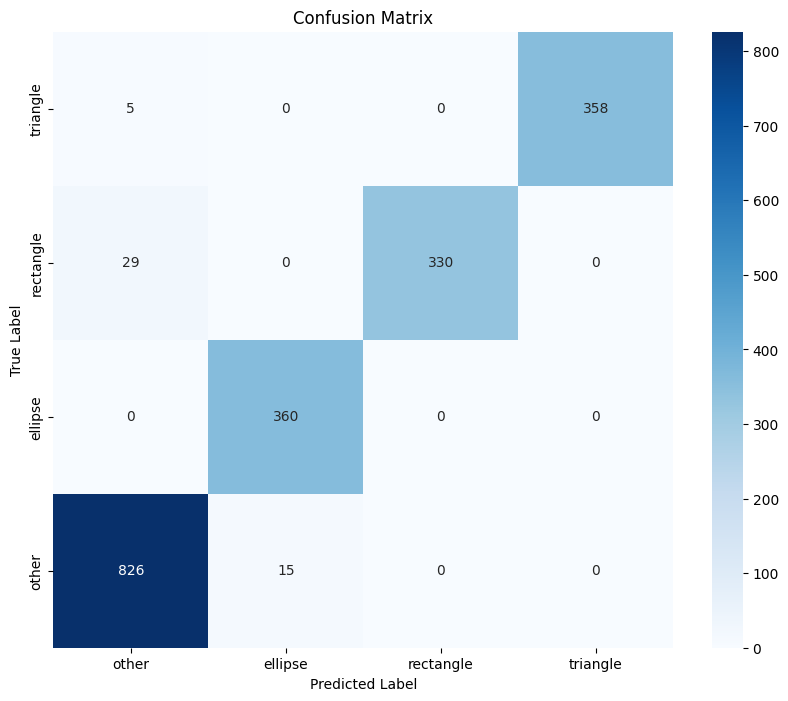

In [24]:
visualize_tests(model)

## IV. Conclusion

Ce document démontre l'efficacité des réseaux de neurones convolutifs (CNN) pour catégoriser des formes dessinées à la main, soulignant leur aptitude à interpréter des données visuelles complexes. À partir d'une base théorique solide sur les CNN, nous avons préparé un dataset structuré en ensembles de train, validation, et test, et effectué un prétraitement et une normalisation des images pour maximiser l'apprentissage.

En conclusion, le modèle fonctionne bien et remplit sa fonction de classification de forme pour notre whiteboard intelligent.

## V. Quelques sources scientifiques utilisées

1. **Conv2D avec padding 'same'**:
   - **Justification**: Les couches Conv2D permettent d'extraire des caractéristiques locales de l'image d'entrée. Le padding 'same' est utilisé pour conserver les dimensions spatiales de l'image à travers les couches convolutives.
   - **Référence**: Simonyan, K., & Zisserman, A. (2014). Very Deep Convolutional Networks for Large-Scale Image Recognition. arXiv:1409.1556. Ce papier introduit VGG, une architecture profonde qui utilise des convolutions avec padding 'same' pour préserver les dimensions.

2. **BatchNormalization**:
   - **Justification**: La normalisation par lots accélère la formation en réduisant le problème du décalage de la distribution des entrées des couches au cours de l'entraînement. Cette couche est entraînable pour ajuster la normalisation et la rendre la plus bénéfique possible au modèle.
   - **Référence**: Ioffe, S., & Szegedy, C. (2015). Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift. arXiv:1502.03167. Ce papier présente BatchNormalization et explique comment elle améliore l'entraînement des réseaux profonds.

3. **Activation Mish**:
   - **Justification**: Mish est une fonction d'activation non linéaire qui peut améliorer la capacité du modèle à apprendre des fonctions complexes.
   - **Référence**: Misra, D. (2019). Mish: A Self Regularized Non-Monotonic Neural Activation Function. arXiv:1908.08681. Cette étude introduit Mish et démontre ses avantages par rapport à d'autres fonctions d'activation comme ReLU.

4. **MaxPooling2D**:
   - **Justification**: Le pooling maximal réduit les dimensions spatiales de l'entrée, ce qui diminue le nombre de paramètres et de calculs nécessaires dans le réseau, tout en conservant les caractéristiques importantes.
   - **Référence**: Boureau, Y. L., Ponce, J., & LeCun, Y. (2010). A Theoretical Analysis of Feature Pooling in Visual Recognition. Proceedings of the 27th International Conference on International Conference on Machine Learning. Cette recherche explore l'impact du pooling (y compris le max pooling) sur la reconnaissance visuelle.

5. **Dropout**:
   - **Justification**: Dropout est une technique de régularisation qui aide à prévenir le surapprentissage en "abandonnant" aléatoirement une partie des unités neuronales pendant l'entraînement.
   - **Référence**: Srivastava, N., Hinton, G., Krizhevsky, A., Sutskever, I., & Salakhutdinov, R. (2014). Dropout: A Simple Way to Prevent Neural Networks from Overfitting. Journal of Machine Learning Research, 15, 1929-1958. Ce papier présente Dropout et démontre son efficacité pour réduire le surapprentissage.

6. **Dense + Softmax** pour la classification:
   - **Justification**: Une couche dense est utilisée pour apprendre des combinaisons non-linéaires des caractéristiques extraites, et la fonction d'activation softmax est utilisée dans la couche de sortie pour obtenir une distribution de probabilité sur les classes.
   - **Référence**: Goodfellow, I., Bengio, Y., Courville, A., & Bengio, Y. (2016). Deep Learning. MIT Press. Le livre offre une vue d'ensemble des réseaux de neurones, y compris l'utilisation de softmax pour la classification.

7. **Adam Optimizer**:
   - **Justification**: Adam est un optimiseur qui ajuste le taux d'apprentissage de manière adaptative pour chaque paramètre, ce qui le rend efficace pour de nombreux problèmes de deep learning. Adam fonctionne par la fonction mathématique de descente stochastique de gradients.
   - **Référence**: Kingma, D. P., & Ba, J. (2014). Adam: A Method for Stochastic Optimization. arXiv:1412.6980. Ce papier introduit Adam et explique comment il fonctionne.

8. **ImageDataGenerator pour l'augmentation de données**:
   - **Justification**: L'augmentation de données est une technique qui crée artificiellement de nouveaux exemples d'entraînement par des transformations aléatoires des données existantes, aidant ainsi à réduire le surapprentissage.
   - **Référence**: Shorten, C., & Khoshgoftaar, T. M. (2019). A Survey on Image Data Augmentation for Deep Learning. Journal of Big Data, 6(1), 60. Cette revue détaille différentes techniques d'augmentation de données et leur impact sur l'apprentissage profond.

9. **ReduceLROnPlateau**:
   - **Justification**: Réduire le taux d'apprentissage lorsque la métrique de performance cesse de s'améliorer peut conduire à une convergence plus fine vers le minimum de la fonction de perte.
   - **Référence**: Bengio, Y. (2012). Practical Recommendations for Gradient-Based Training of Deep Architectures. In Neural Networks: Tricks of the Trade. Ce travail donne des recommandations sur l'ajustement du taux d'apprentissage pour améliorer l'entraînement des réseaux profonds.